In [220]:
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

from textwrap import wrap

In [221]:
df = pd.read_csv('../rapid_news_cleaned.csv', parse_dates=True, index_col='date').dropna()
df.head()

,body,description,search_string,title
date,,,,
2021-04-05,tweet bumbl nasdaq bmbl recent receiv number p...,bumbl nasdaq bmbl recent receiv number price t...,bumble,week invest analyst rate updat bumbl bmbl
2021-04-03,bmbl stock open wednesday compani day averag b...,wolf research began coverag share bumbl nasdaq...,bumble,bumbl nasdaq bmbl cover wolf research
2021-03-31,style kevin hold groom franco vallelonga era a...,style kevin hold groom franco vallelonga era a...,bumble,thoma penfound archiv
2021-03-31,equiti research analyst wolf research initi co...,equiti research analyst wolf research initi co...,bumble,bumbl nasdaq bmbl research coverag start wolf ...
2021-03-31,serena william perfect martha stewart home dec...,serena william perfect martha stewart home dec...,bumble,serena william gave home tour kitchen martha s...


## Sentiment
Add sentiment using Vader/TextBlob

In [222]:
def get_textblob_sentiment(string):
    return TextBlob(string).sentiment.polarity


analyzer = SentimentIntensityAnalyzer()
def get_vader_sentiment(string):
    return analyzer.polarity_scores(string)['compound']

In [223]:
df['body_vader'] = df.body.apply(get_vader_sentiment)
df['body_textblob'] = df.body.apply(get_textblob_sentiment)

df['description_vader'] = df.description.apply(get_vader_sentiment)
df['description_textblob'] = df.description.apply(get_textblob_sentiment)

df['title_vader'] = df.title.apply(get_vader_sentiment)
df['title_textblob'] = df.title.apply(get_textblob_sentiment)

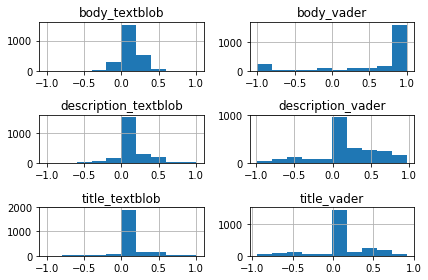

In [224]:
df.hist()
plt.tight_layout()

From these histograms, we can see that description will likely be the best judge of sentiment.
The body may be too noisy (causing a clear difference between vader and textblob), and title may
not give enough info (most of the sentiment seems to be neutral). We continue by using the descrption.

In [225]:
df_sentiment_scores = df[['description_vader', 'description_textblob']]

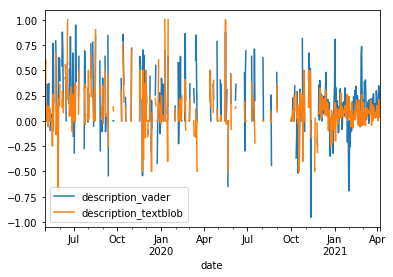

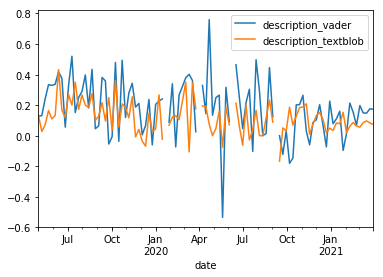

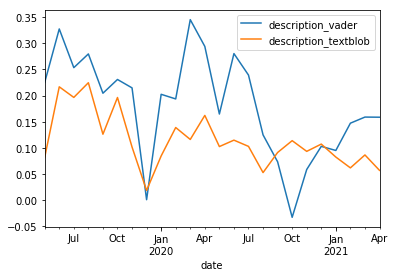

In [226]:
df_sentiment_scores.resample('1D').mean().plot()
df_sentiment_scores.resample('7D').mean().plot()
df_sentiment_scores.resample('1M').mean().plot()

Since there are a lot of neutral values, we may want to see the average sentiment across stronger descriptions.

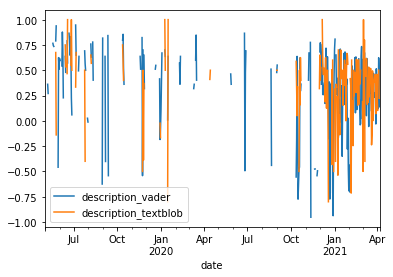

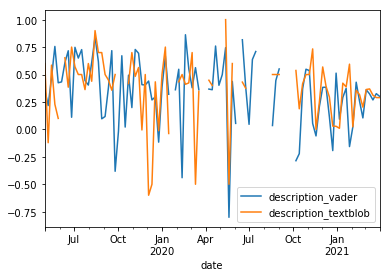

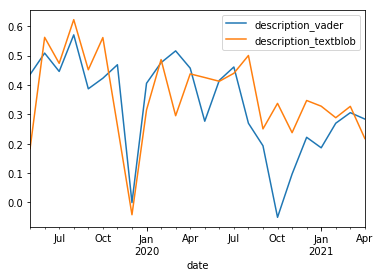

In [227]:
df_sentiment_scores.resample('1D').apply(lambda x: x[(x > 0.3) | (x < -0.3)].mean()).plot()
df_sentiment_scores.resample('7D').apply(lambda x: x[(x > 0.3) | (x < -0.3)].mean()).plot()
df_sentiment_scores.resample('1M').apply(lambda x: x[(x > 0.3) | (x < -0.3)].mean()).plot()

Only positive reviews

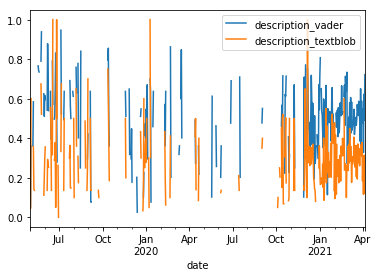

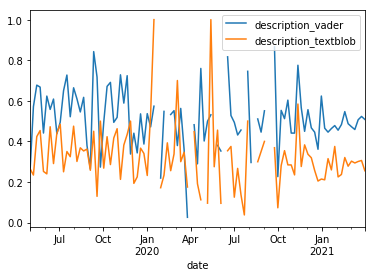

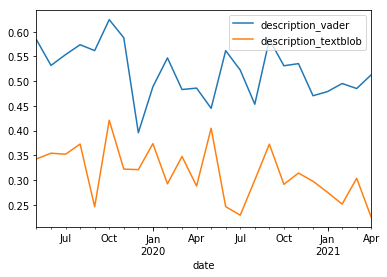

In [228]:
df_sentiment_scores.resample('1D').apply(lambda x: x[x > 0].mean()).plot()
df_sentiment_scores.resample('7D').apply(lambda x: x[x > 0].mean()).plot()
df_sentiment_scores.resample('1M').apply(lambda x: x[x > 0].mean()).plot()

Only negative reviews

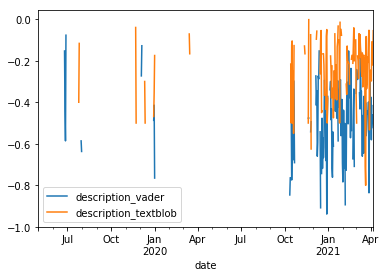

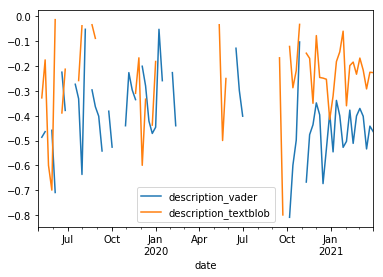

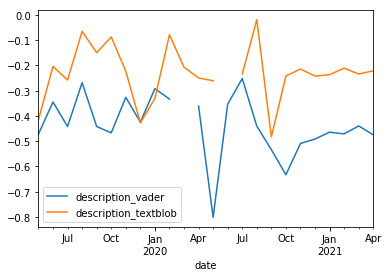

In [229]:
df_sentiment_scores.resample('1D').apply(lambda x: x[x < 0].mean()).plot()
df_sentiment_scores.resample('7D').apply(lambda x: x[x < 0].mean()).plot()
df_sentiment_scores.resample('1M').apply(lambda x: x[x < 0].mean()).plot()

There doesn't seem to be much interesting by looking at the average sentiment over time. We do, however, see two heavy drops
in the graph (although part of it might be due to missing data).

## EDA
High level analysis

### All reviews

In [230]:
processed_docs = df.description.apply(lambda x: x.split())
dictionary = gensim.corpora.Dictionary(processed_docs)

id2token = {v: k for k, v in dictionary.token2id.items()}
freq = sorted([(id2token[id], count) for id, count in dictionary.cfs.items()], key=lambda x: -x[1])[:50]
freq[:50]

[('date', 1643),
 ('app', 770),
 ('bumbl', 738),
 ('tinder', 622),
 ('new', 276),
 ('user', 219),
 ('onlin', 199),
 ('public', 190),
 ('share', 189),
 ('peopl', 188),
 ('match', 185),
 ('report', 181),
 ('women', 170),
 ('compani', 162),
 ('relationship', 156),
 ('offer', 155),
 ('look', 154),
 ('initi', 153),
 ('love', 148),
 ('like', 143),
 ('news', 139),
 ('year', 137),
 ('time', 127),
 ('stock', 125),
 ('price', 102),
 ('swipe', 98),
 ('meet', 97),
 ('site', 95),
 ('woman', 94),
 ('featur', 93),
 ('man', 91),
 ('wolf', 90),
 ('profil', 90),
 ('want', 90),
 ('star', 89),
 ('bmbl', 87),
 ('billion', 86),
 ('market', 85),
 ('pandem', 83),
 ('best', 82),
 ('right', 82),
 ('group', 81),
 ('life', 80),
 ('herd', 80),
 ('popular', 80),
 ('singl', 80),
 ('check', 79),
 ('partner', 77),
 ('start', 77),
 ('whitney', 76)]

These words seem to make sense given that the topic is Bumble, a dating app.

In [231]:
cv=CountVectorizer(analyzer='word')

words_by_month = df.description.resample('1M').apply(lambda x: ' '.join(x))
data=cv.fit_transform(words_by_month)
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=words_by_month.index
df_dtm.head()

,aaron,aaryan,aback,abandon,abb,abbi,abbott,abc,abdelaziz,abelist,...,zina,zo,zodiac,zoe,zomato,zoo,zoom,zoomland,zoosk,zurick
date,,,,,,,,,,,,,,,,,,,,,
2019-05-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-06-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2019-07-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2019-08-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-09-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


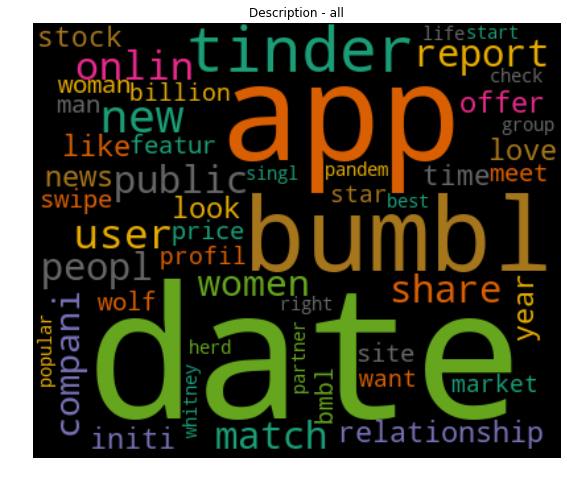

In [232]:
wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(dict(freq))
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Description - all')
plt.show()

In [233]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [234]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=5, workers=5)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.055*"date" + 0.010*"onlin" + 0.009*"site" + 0.008*"relationship" + 0.008*"new" + 0.008*"tinder" + 0.007*"year" + 0.006*"app" + 0.005*"peopl" + 0.005*"pandem"
Topic: 1 
Words: 0.049*"date" + 0.032*"tinder" + 0.030*"app" + 0.020*"bumbl" + 0.010*"match" + 0.010*"user" + 0.008*"report" + 0.007*"new" + 0.005*"check" + 0.005*"look"
Topic: 2 
Words: 0.024*"date" + 0.010*"news" + 0.009*"time" + 0.007*"new" + 0.007*"bumbl" + 0.007*"peopl" + 0.007*"app" + 0.005*"post" + 0.005*"rumor" + 0.004*"page"
Topic: 3 
Words: 0.031*"date" + 0.023*"bumbl" + 0.020*"app" + 0.011*"tinder" + 0.009*"new" + 0.008*"user" + 0.008*"swipe" + 0.008*"women" + 0.007*"right" + 0.006*"onlin"
Topic: 4 
Words: 0.033*"date" + 0.031*"bumbl" + 0.019*"app" + 0.017*"public" + 0.014*"initi" + 0.013*"offer" + 0.011*"share" + 0.010*"compani" + 0.009*"billion" + 0.008*"stock"


In [235]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.005*"bumbl" + 0.005*"app" + 0.005*"date" + 0.004*"public" + 0.004*"tinder" + 0.003*"new" + 0.003*"initi" + 0.003*"herd" + 0.003*"user" + 0.003*"wolf"
Topic: 1 Word: 0.005*"tinder" + 0.005*"app" + 0.005*"date" + 0.004*"bumbl" + 0.003*"user" + 0.003*"background" + 0.003*"match" + 0.003*"check" + 0.003*"onlin" + 0.003*"peopl"
Topic: 2 Word: 0.004*"bumbl" + 0.003*"report" + 0.003*"app" + 0.003*"date" + 0.003*"tinder" + 0.003*"share" + 0.002*"new" + 0.002*"compani" + 0.002*"stock" + 0.002*"public"
Topic: 3 Word: 0.005*"date" + 0.005*"app" + 0.004*"bumbl" + 0.004*"tinder" + 0.003*"match" + 0.003*"user" + 0.003*"new" + 0.003*"swipe" + 0.003*"public" + 0.003*"relationship"
Topic: 4 Word: 0.004*"date" + 0.003*"tinder" + 0.003*"app" + 0.003*"news" + 0.003*"bumbl" + 0.002*"compani" + 0.002*"love" + 0.002*"peopl" + 0.002*"share" + 0.002*"year"


These models seem to suggest two main topics - the first has to do with bumble becoming a public company.
The second has to do with normal news around a new dating app (probably more in line with advertising / promoting bumble).
The TfIDF model also has a topic pertaining to the CEO, although this would likely be more related to the frist topic.

### Positive articles

In [236]:
processed_docs = df.description[df.description_textblob > 0].apply(lambda x: x.split())
dictionary = gensim.corpora.Dictionary(processed_docs)

id2token = {v: k for k, v in dictionary.token2id.items()}
freq = sorted([(id2token[id], count) for id, count in dictionary.cfs.items()], key=lambda x: -x[1])[:50]
freq[:50]

[('date', 766),
 ('app', 379),
 ('tinder', 302),
 ('bumbl', 299),
 ('new', 243),
 ('love', 136),
 ('onlin', 106),
 ('peopl', 103),
 ('match', 95),
 ('user', 95),
 ('look', 94),
 ('best', 81),
 ('popular', 79),
 ('women', 73),
 ('like', 72),
 ('right', 72),
 ('share', 70),
 ('time', 70),
 ('year', 68),
 ('public', 68),
 ('relationship', 67),
 ('compani', 66),
 ('swipe', 58),
 ('offer', 57),
 ('featur', 57),
 ('initi', 54),
 ('site', 53),
 ('life', 52),
 ('report', 52),
 ('meet', 51),
 ('help', 49),
 ('social', 48),
 ('good', 48),
 ('profil', 48),
 ('day', 47),
 ('want', 47),
 ('live', 44),
 ('sexual', 44),
 ('know', 44),
 ('person', 44),
 ('world', 41),
 ('news', 41),
 ('man', 41),
 ('star', 40),
 ('pandem', 40),
 ('wolf', 40),
 ('singl', 40),
 ('free', 39),
 ('way', 39),
 ('use', 39)]

In [237]:
cv=CountVectorizer(analyzer='word')

words_by_month = df.description[df.description_textblob > 0].resample('1M').apply(lambda x: ' '.join(x))
data=cv.fit_transform(words_by_month)
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=words_by_month.index
df_dtm.head()

,aaron,aaryan,abandon,abc,abil,abl,ableism,absolut,abus,abuzz,...,zealand,zee,zest,zig,zimbabw,zodiac,zoe,zomato,zoo,zoosk
date,,,,,,,,,,,,,,,,,,,,,
2019-05-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-06-30,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2019-07-31,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2019-08-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-09-30,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


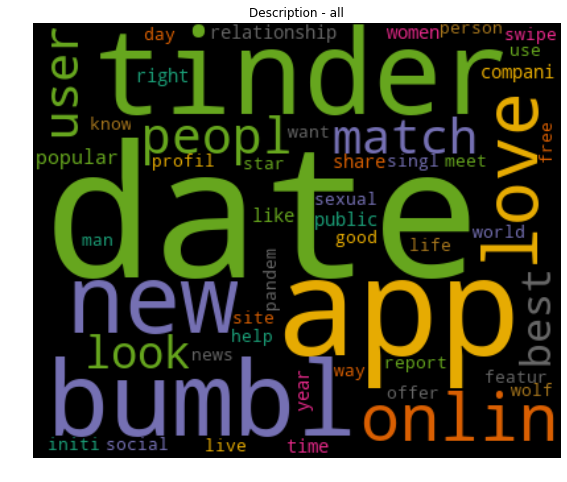

In [238]:
wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(dict(freq))
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Description - Positive')
plt.show()

In [239]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [240]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=5, workers=5)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.033*"date" + 0.015*"love" + 0.014*"new" + 0.013*"app" + 0.011*"tinder" + 0.009*"look" + 0.009*"help" + 0.008*"peopl" + 0.007*"best" + 0.007*"onlin"
Topic: 1 
Words: 0.042*"date" + 0.032*"tinder" + 0.029*"app" + 0.018*"bumbl" + 0.012*"user" + 0.011*"new" + 0.011*"match" + 0.008*"right" + 0.008*"peopl" + 0.007*"swipe"
Topic: 2 
Words: 0.048*"date" + 0.024*"bumbl" + 0.022*"app" + 0.009*"new" + 0.009*"onlin" + 0.008*"share" + 0.008*"public" + 0.006*"initi" + 0.006*"trade" + 0.006*"wolf"
Topic: 3 
Words: 0.024*"date" + 0.013*"new" + 0.010*"app" + 0.008*"tinder" + 0.008*"life" + 0.007*"peopl" + 0.005*"star" + 0.005*"pandem" + 0.005*"latest" + 0.004*"love"
Topic: 4 
Words: 0.028*"date" + 0.017*"new" + 0.010*"bumbl" + 0.007*"time" + 0.006*"man" + 0.006*"app" + 0.006*"look" + 0.005*"relationship" + 0.005*"women" + 0.005*"star"


In [241]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.005*"app" + 0.004*"bumbl" + 0.004*"date" + 0.004*"love" + 0.004*"tinder" + 0.003*"public" + 0.003*"look" + 0.003*"new" + 0.003*"popular" + 0.003*"compani"
Topic: 1 Word: 0.004*"date" + 0.003*"bumbl" + 0.003*"app" + 0.003*"new" + 0.003*"tinder" + 0.003*"best" + 0.003*"onlin" + 0.002*"peopl" + 0.002*"latest" + 0.002*"women"
Topic: 2 Word: 0.004*"app" + 0.003*"bumbl" + 0.003*"date" + 0.003*"tinder" + 0.003*"new" + 0.003*"featur" + 0.003*"right" + 0.002*"best" + 0.002*"match" + 0.002*"like"
Topic: 3 Word: 0.003*"tinder" + 0.003*"bumbl" + 0.003*"app" + 0.003*"new" + 0.003*"date" + 0.002*"public" + 0.002*"user" + 0.002*"initi" + 0.002*"better" + 0.002*"star"
Topic: 4 Word: 0.004*"love" + 0.004*"new" + 0.004*"tinder" + 0.004*"date" + 0.004*"app" + 0.003*"onlin" + 0.003*"relationship" + 0.003*"bumbl" + 0.002*"peopl" + 0.002*"man"


This doesn't seem to make an obvious difference from including all articles.


### Negative articles

In [242]:
processed_docs = df.description[df.description_textblob < 0].apply(lambda x: x.split())
dictionary = gensim.corpora.Dictionary(processed_docs)

id2token = {v: k for k, v in dictionary.token2id.items()}
freq = sorted([(id2token[id], count) for id, count in dictionary.cfs.items()], key=lambda x: -x[1])[:50]
freq[:50]


[('date', 260),
 ('bumbl', 126),
 ('app', 110),
 ('tinder', 82),
 ('report', 54),
 ('share', 50),
 ('price', 41),
 ('stock', 40),
 ('user', 38),
 ('bmbl', 33),
 ('new', 33),
 ('onlin', 32),
 ('peopl', 32),
 ('initi', 30),
 ('base', 30),
 ('target', 29),
 ('rate', 27),
 ('nasdaq', 26),
 ('like', 26),
 ('compani', 26),
 ('game', 26),
 ('firm', 24),
 ('relationship', 24),
 ('research', 23),
 ('coverag', 23),
 ('offer', 22),
 ('public', 22),
 ('start', 22),
 ('year', 22),
 ('look', 22),
 ('match', 22),
 ('set', 20),
 ('potenti', 20),
 ('previous', 20),
 ('site', 20),
 ('women', 19),
 ('partner', 19),
 ('time', 19),
 ('fake', 19),
 ('issu', 18),
 ('market', 18),
 ('profil', 18),
 ('analyst', 17),
 ('group', 17),
 ('news', 17),
 ('wolf', 16),
 ('bad', 16),
 ('monday', 15),
 ('pandem', 15),
 ('meet', 14)]

In [243]:
cv=CountVectorizer(analyzer='word')

words_by_month = df.description[df.description_textblob < 0].resample('1M').apply(lambda x: ' '.join(x))
data=cv.fit_transform(words_by_month)
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=words_by_month.index
df_dtm.head()

,aaron,abb,abc,abigail,abl,abnb,abrupt,abus,abyss,academi,...,young,younger,youngest,youv,yungblud,zealand,zest,zina,zodiac,zoom
date,,,,,,,,,,,,,,,,,,,,,
2019-05-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-06-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-07-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-08-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-09-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


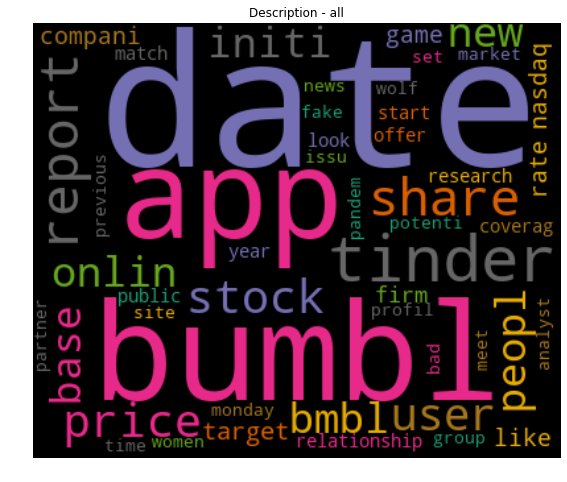

In [244]:
wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(dict(freq))
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Description - Negative')
plt.show()

In [245]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [246]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=5, workers=5)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.049*"date" + 0.024*"app" + 0.023*"bumbl" + 0.010*"tinder" + 0.010*"user" + 0.009*"fake" + 0.008*"compani" + 0.007*"onlin" + 0.007*"stone" + 0.007*"sharon"
Topic: 1 
Words: 0.039*"date" + 0.019*"bumbl" + 0.016*"app" + 0.012*"tinder" + 0.009*"game" + 0.008*"base" + 0.008*"initi" + 0.007*"offer" + 0.006*"peopl" + 0.006*"public"
Topic: 2 
Words: 0.018*"bumbl" + 0.011*"app" + 0.011*"wolf" + 0.010*"herd" + 0.010*"share" + 0.009*"whitney" + 0.008*"date" + 0.007*"tinder" + 0.007*"relationship" + 0.006*"peopl"
Topic: 3 
Words: 0.041*"date" + 0.019*"tinder" + 0.016*"app" + 0.012*"bumbl" + 0.008*"user" + 0.007*"like" + 0.007*"site" + 0.006*"peopl" + 0.006*"report" + 0.006*"pandem"
Topic: 4 
Words: 0.025*"date" + 0.019*"stock" + 0.017*"report" + 0.013*"price" + 0.013*"share" + 0.012*"bmbl" + 0.011*"coverag" + 0.011*"bumbl" + 0.011*"target" + 0.010*"rate"


In [247]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.003*"report" + 0.003*"crime" + 0.003*"tinder" + 0.003*"pandem" + 0.003*"date" + 0.003*"bumbl" + 0.003*"violent" + 0.002*"compani" + 0.002*"price" + 0.002*"difficult"
Topic: 1 Word: 0.003*"date" + 0.003*"report" + 0.003*"app" + 0.003*"bumbl" + 0.003*"facebook" + 0.002*"price" + 0.002*"stock" + 0.002*"billion" + 0.002*"start" + 0.002*"year"
Topic: 2 Word: 0.004*"app" + 0.003*"date" + 0.003*"bumbl" + 0.003*"mad" + 0.002*"sharon" + 0.002*"stone" + 0.002*"user" + 0.002*"tinder" + 0.002*"account" + 0.002*"fake"
Topic: 3 Word: 0.005*"app" + 0.004*"tinder" + 0.004*"date" + 0.003*"bumbl" + 0.003*"new" + 0.003*"peopl" + 0.003*"public" + 0.003*"offer" + 0.003*"initi" + 0.003*"question"
Topic: 4 Word: 0.004*"bumbl" + 0.004*"profil" + 0.003*"fake" + 0.003*"date" + 0.003*"user" + 0.003*"onlin" + 0.003*"stone" + 0.003*"sharon" + 0.003*"report" + 0.003*"tinder"


Here, we can see that there is somewhat of a new topic: fake users. There are also some other topics that do not seem
immediately obvious as to what topic they refer to.